# Business Case 2

Group members:
- Lorenzo Pigozzi	--- m20200745
- Nguyen Huy Phuc	--- m20200566
- Ema Mandura	  --- m20200647


## Hotel's Booking Cancelation prediction

In the hotel industry, the relationship between a guest and the hotel is established through a booking. This contract is made with a specified cancellation policy, which can potentially be damaging to the hotel. When a cancellation is made close to the date of the reservation, the hotel might not be able to rent the room to a new guest or will be forced to rent it for a smaller price. 

With a predictive model, hotels can forecast net demand based on reservations on-the-books. By identifying customers that are likely to make a cancellation, the hotel can adjust prices and use overbooking accordingly.  

**Back ground:**
Hotel chain C holds multiple resort and city hotels across Portugal. For their hotels H1 and H2, they suffered respectively 28% and 42% of their bookings worth in cancellations. In this project, we will try to create a predictive model to predict whether a customer will cancel a booking or not

- **Predictive model objectives:**
    - Forecast net demand based on reservations
    - Pricing strategy and overbooking policies
    - Identifying high potential in cancellation customers


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing data and libraries](#1)   
2.	[Exploratory data analysis (EDA)](#2)       
3.	[Data preprocessing](#3)  
4.  [Modeling](#4)      
5.  [Evaluation](#5)
6.  [Deployment](#6)

# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import math
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from joblib import dump
import time
# Sklearn
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import precision_score, accuracy_score,auc, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve,recall_score
from sklearn.ensemble import RandomForestClassifier
#sklearn categorical encoding
import category_encoders as ce
#sklearn modelling
from sklearn.model_selection import StratifiedKFold,GridSearchCV, cross_val_score, learning_curve, train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
#saving model and encoder
import pickle
#Light GBM
import lightgbm as lgb



#PROJECT_ROOT = Path(os.path.abspath('')).resolve()
#warnings
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True


In [2]:
data = pd.read_csv('data/H2.csv')

In [3]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [4]:
# remove all the unwanted spaces in the data
data.loc[:,data.dtypes == "O"] = data.loc[:,data.dtypes == "O"].apply(lambda x : x.str.strip())

In [5]:
# defining numeric, categorical and target features
numeric_feats = data.loc[:,data.dtypes != "O"].columns.drop('IsCanceled')
cat_feats = data.loc[:,data.dtypes == "O"].columns
target = 'IsCanceled'

# 2. Exploratory data analysis (EDA) <a class="anchor" id="2"></a>

### Define functions

In [6]:
#find features with correlations greater than 0.9 in order to remove them
def correlation_check(df, limit = 0.90, drop = False):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    corr_no_diag = corr.where(mask)
    coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]        
    #df.drop(coll,axis = 1,inplace=True)
    print('High correlation columns are:', coll)
def corrheatmap(dataframe):
    sns.set(style="whitegrid")
    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)
    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

def boxplot_withoutLabels(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(y=df.loc[:,i[1]], ax=i[0], color='r')      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)

    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def displot_all(df, columns, target):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.histplot(x=df.loc[:,i[1]], ax=i[0], hue = df[target],palette="icefire")      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Dist plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def countplot_all(df, columns):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.countplot(x=df.loc[:,i[1]], ax=i[0],palette="icefire")      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Count plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe, method = "pearson"):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr(method= method) #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True,annot=True, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0, fontsize = 14)
    plt.xticks(rotation=90, fontsize = 14)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()      
    
def weight_of_variable(df, column, target, plot = True, sortby = 'Total count'):
    # Count total observations
    total = df[[column, target]].groupby(by = column,).count().sort_values(by = target, ascending = False)

    # Count
    with_target = df[[column, target]].groupby(by = column).sum().sort_values(by = target, ascending = False)
    
    weight = (df[[column, target]].groupby(by = column).sum().sort_values(by = target, ascending = False) / 
    (df[[column, target]].groupby(by = column).count().sort_values(by = target, ascending = False))).sort_values(by = target, ascending = False)
    
    concat_df = pd.concat([total, with_target, weight],axis = 1)
    
    out = pd.DataFrame(concat_df.values,index=concat_df.index, columns=['Total count', 'Cancelled count', 'Weight'])
    # Explore feature vs target by catplot
    if plot == True:
        g = sns.catplot(x=target,y=column,data=df,kind="bar", size = 4 , palette = "icefire",orient='h',height=.5, aspect=2)
        #g.set(ylim=(lower, upper)) 
        g.despine(left=True)
        g.fig.set_figwidth(8)
        g.fig.set_figheight(3*ceil(len(df[column].unique())/10))
        g.set_ylabels("Categories")
        # Rotate the labels
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(-45)

    return out.astype({'Total count':'int', 'Cancelled count':'int64'}).sort_values(by = sortby ,ascending = False)

## 2.1. Exploration of data with technical context

### Check for missing values:

In [7]:
data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

The amount of missing data is too few to create damage to the model. Thus, we decided to drop them.

### Checking duplicated observations

In [8]:
# Checking duplicated observations
data.loc[data.duplicated(keep=False), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
10,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79312,0,175,2017,August,35,31,1,3,1,0.0,...,No Deposit,42,NULL,0,Transient,82.35,0,1,Check-Out,2017-09-04


There are a lot of duplicate observations in the dataset. However, since we can not explicitly prove that these observation are whether duplicated or coincident. We will keep all these duplicated values and accepted them as odds

### Check for variables univariate distribution

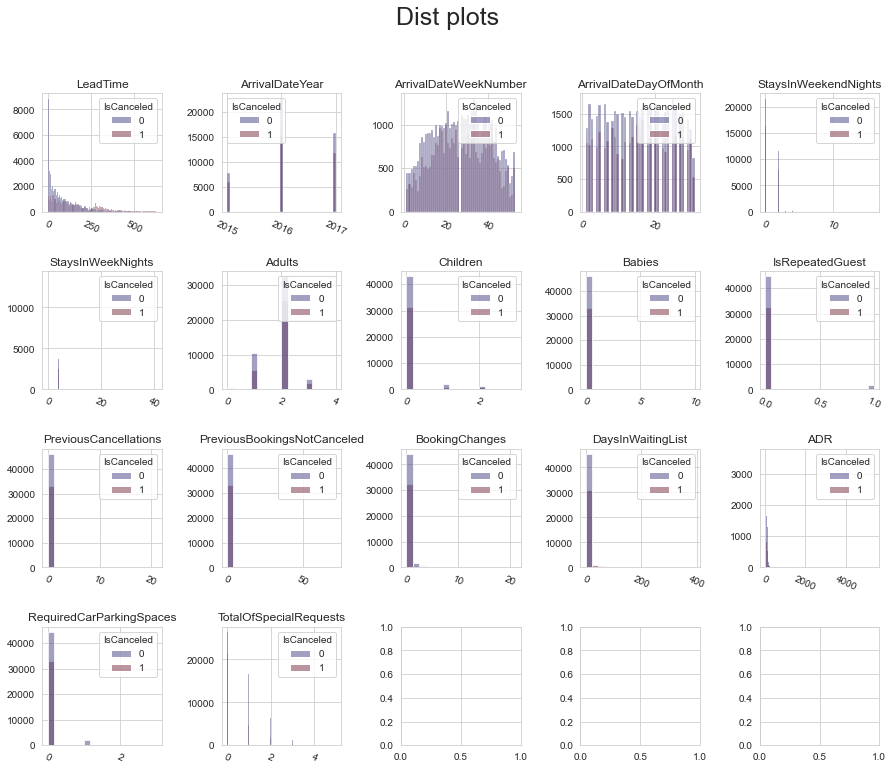

In [9]:
displot_all(data,numeric_feats,target=target)  

A lot of features have outliners, I think in the next EDA steps, we should divide the features by their charatacteristics and try to understand them

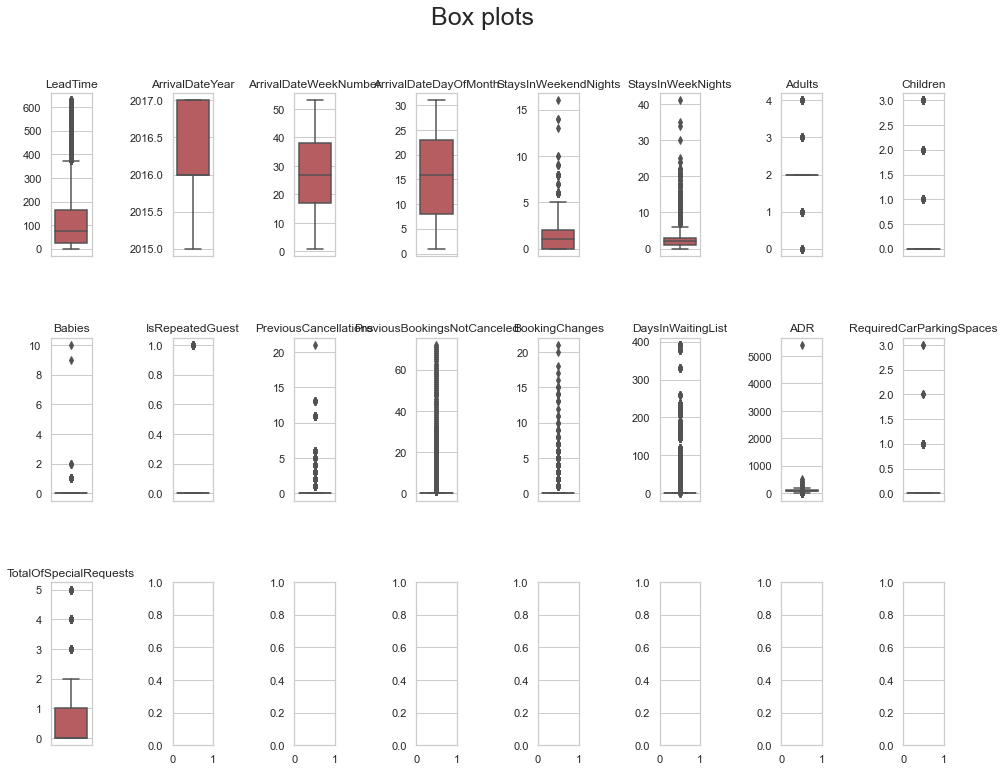

In [10]:
boxplot_withoutLabels(data[numeric_feats])

### Checking outliers of `ADR` 

<AxesSubplot:xlabel='ADR'>

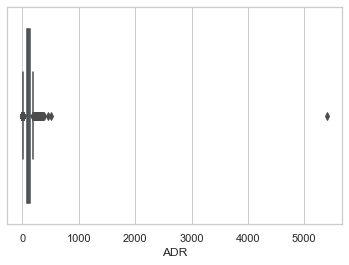

In [11]:
sns.boxplot(data=data,x = "ADR", hue = "IsCanceled")

In [12]:
data[data['ADR'] >1000]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8455,1,35,2016,March,13,25,0,1,2,0.0,...,Non Refund,12,NULL,0,Transient,5400.0,0,0,Canceled,2016-02-19


`ADR` feature have an outlier of more than 5000 values of ADR, we will remove from the model as this is an abnomalie that will harm the performance of the model

In [13]:
outlier_index = data[data['ADR'] >1000].index

### Checking outliers of `Babies` 

<AxesSubplot:xlabel='Babies'>

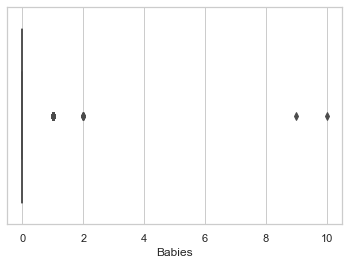

In [14]:
sns.boxplot(data=data,x = "Babies", hue = "IsCanceled")

In [15]:
data[data['Babies'] >4]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
6559,0,37,2016,January,3,12,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,84.45,0,1,Check-Out,2016-01-14
38596,0,11,2015,October,42,11,2,1,1,0.0,...,No Deposit,95,NULL,0,Transient-Party,95.00,0,0,Check-Out,2015-10-14


There is only 2 outliers in this feature and they are intuitively considered as outlier. We will also consider to remove them

In [16]:
outlier_index = outlier_index.append(data[data['Babies'] >4].index)

In [17]:
# remove the outliers
data.drop(index=outlier_index,inplace=True,errors='ignore')

## 2.2. Exploration of variables with business context

### Will leadtime of bookings affect the cancelation rate?

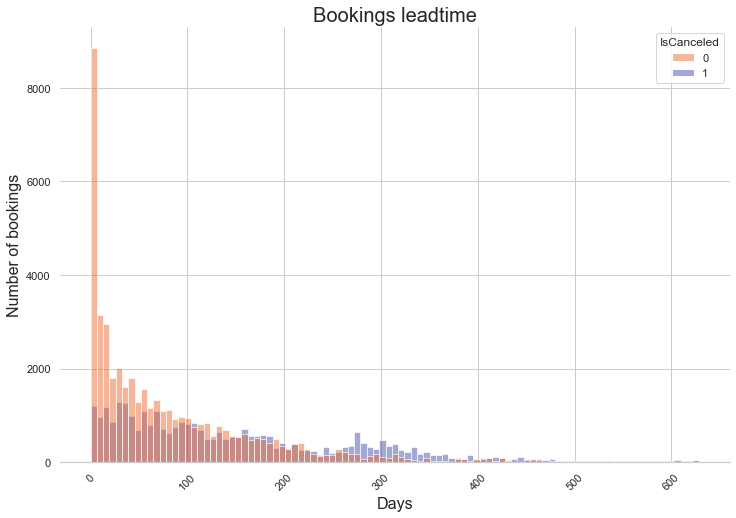

In [18]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.histplot(data=data, x="LeadTime", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Bookings leadtime", fontsize=20)
plt.xlabel("Days", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
#plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

Most of booking for more than 275 days ahead will be canceled. Bookings at 1 day before the arrival has lowest probability of cancelation

### Categorical features distribution

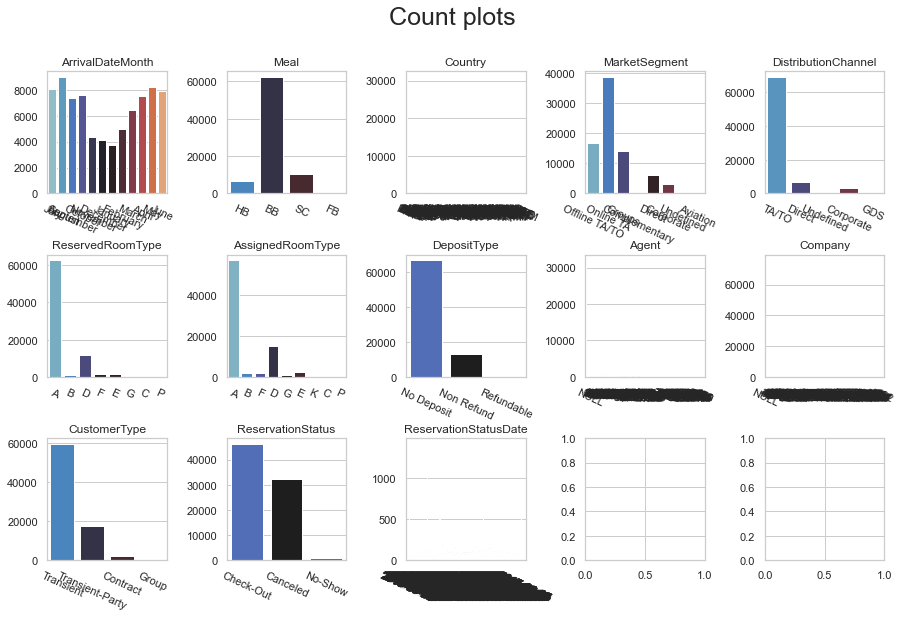

In [19]:
countplot_all(data,cat_feats)

### Reservation Status

,Total count,Cancelled count,Weight
Check-Out,46226,0,0.0
Canceled,32185,32185,1.0
No-Show,916,916,1.0


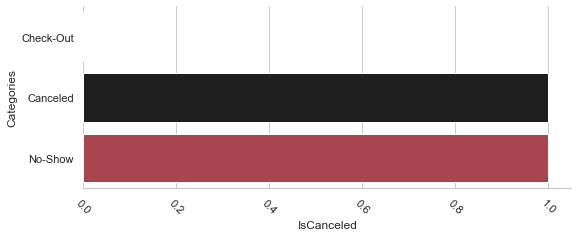

In [20]:
weight_of_variable(data,"ReservationStatus",target)

This features must be removed because it is only available after the customer cancelled. Therefore, having this feature is an target leakage in the model training. The same happens with `ResearvationStatusDate`, which will also be removed

### Customers' country of origin

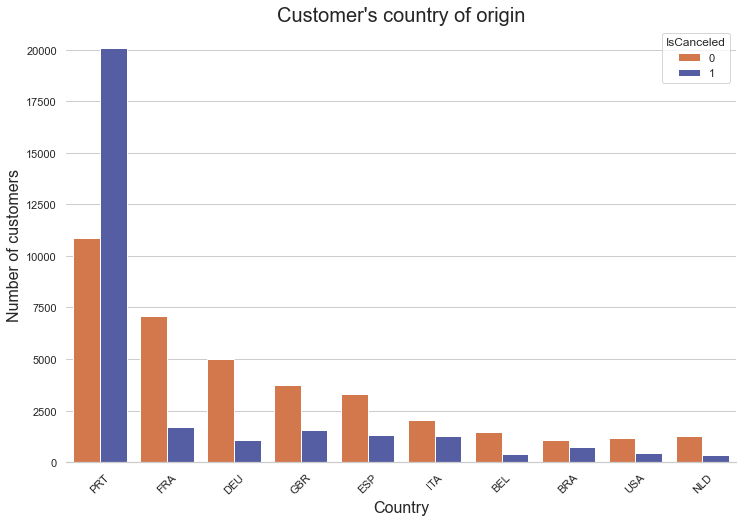

In [21]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="Country", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)],
              order = pd.value_counts(data['Country']).iloc[:10].index)
sns.despine(left=True)
plt.title("Customer's country of origin", fontsize=20)
plt.xlabel("Country", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of customers", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

From the plot above, there are 2 main points need to be pointed out. The first one is that the customers of the hotel mostly come from Portugal, which is quite obvious as the hotel is in Portugal. However, the second point is that the number of canceled bookings from Portugal is extremely high, nearly double the number of confirmed bookings. Nevertheless, the company explained us that this variable is not really reliable, so we will not consider it for the model creation.

### Analyse the time patterns in customer bookings

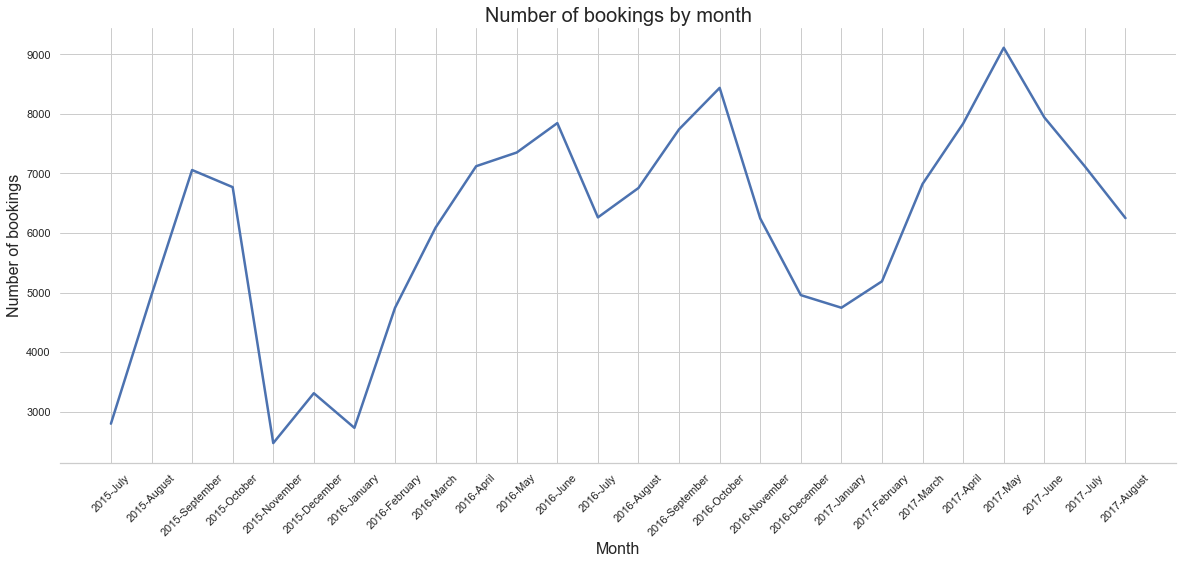

In [22]:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

plt_df = data[['ArrivalDateMonth','ArrivalDateYear']].sort_values('ArrivalDateMonth')
plt_df["ArrivalDateMonth"] = pd.Categorical(plt_df["ArrivalDateMonth"], categories=ordered_months, ordered=True)
plt_df = plt_df.pivot_table(index=['ArrivalDateYear','ArrivalDateMonth'], aggfunc=np.count_nonzero)
plt_df.index = plt_df.index.map('{0[0]}-{0[1]}'.format)
# show figure:
plt.figure(figsize=(20, 8))
sns.lineplot(data=plt_df, palette="icefire", linewidth=2.5,dashes=False)
sns.despine(left=True)
plt.title("Number of bookings by month", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.show()

From the plot, we can clearly see that there is seasonality in the trends of monthly bookings. The summer time from April to October is the best time for the hotel business, especially in tourism-oriented country such as Portugal

### **Meal**

,Total count,Cancelled count,Weight
BB,62302,26666,0.428012
SC,10564,3963,0.375142
HB,6417,2437,0.379772
FB,44,35,0.795455


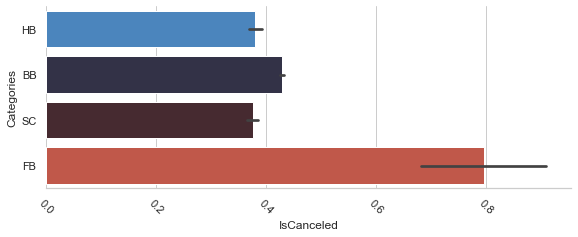

In [23]:
weight_of_variable(data,"Meal",target)

#### Notations:
The probability that customers who chose Full-Board as their meal obtion is the highest amongst all. However, the number of the FB is very small in comparision with the other 3 options given. While Half-board and Undefined is relatively the same, the people with Bed-Breakfast is slightly higher

### Will deposit reduced the probability of canceled bookings?

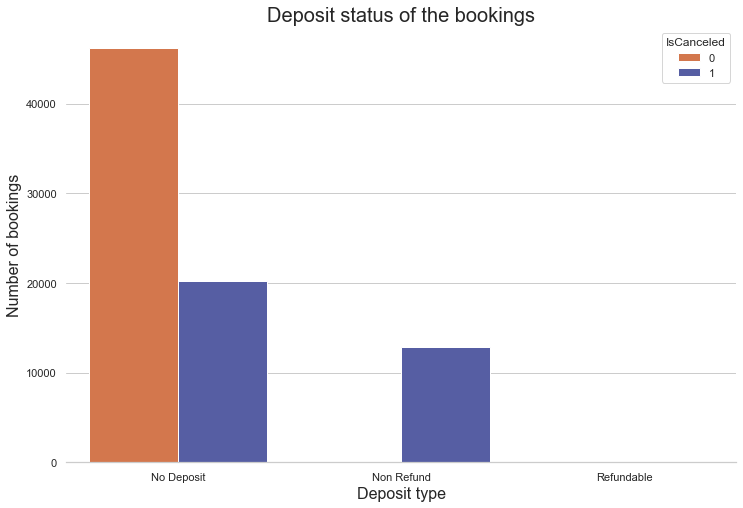

In [24]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="DepositType", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Deposit status of the bookings", fontsize=20)
plt.xlabel("Deposit type", fontsize=16)
#plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

### Do the customers likely to return to the hotel?

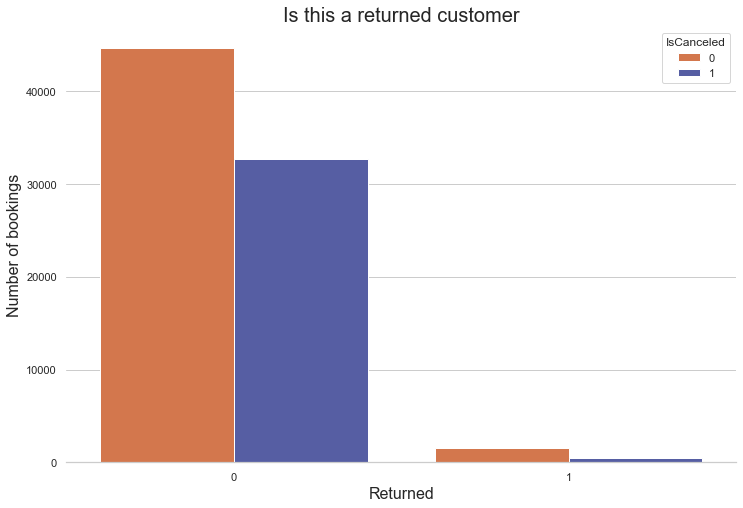

In [25]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="IsRepeatedGuest", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Is this a returned customer", fontsize=20)
plt.xlabel("Returned", fontsize=16)
#plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

Most of the bookings is from new customer, which might means that customer is not likely to return to the hotel after staying. This can be interpreted that this hotel is in the city which attract 1-time tourists and businessmen.

### `MarketSegment`

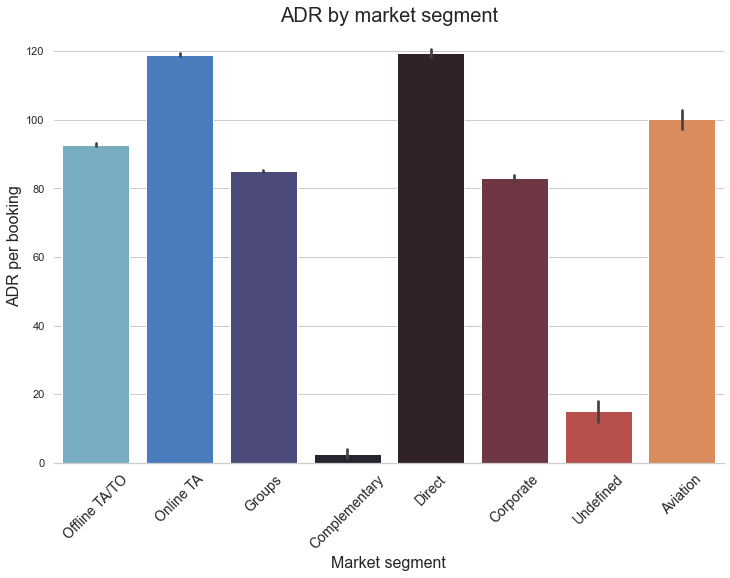

In [26]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.barplot(data=data, x="MarketSegment", y="ADR",
               palette='icefire')
sns.despine(left=True)
plt.title("ADR by market segment", fontsize=20)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(fontsize = 14, rotation=45)
plt.ylabel("ADR per booking", fontsize=16)
#plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

In [27]:
data.shape

(79327, 31)

In [28]:
data[data['LeadTime'] > 250]["IsCanceled"].value_counts()

1    7405
0    2817
Name: IsCanceled, dtype: int64

,Total count,Cancelled count,Weight
Online TA,38747,14491,0.373990
Offline TA/TO,16746,7172,0.428281
Groups,13975,9623,0.688587
Direct,6093,1056,0.173314
Corporate,2985,641,0.214740
Complementary,542,64,0.118081
Aviation,237,52,0.219409
Undefined,2,2,1.000000


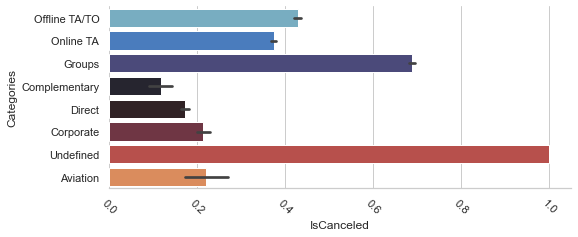

In [29]:
weight_of_variable(data,"MarketSegment","IsCanceled")

### DistributionChannel

,Total count,Cancelled count,Weight
TA/TO,68943,31042,0.450256
Direct,6780,1232,0.181711
Corporate,3407,786,0.230701
GDS,193,37,0.191710
Undefined,4,4,1.000000


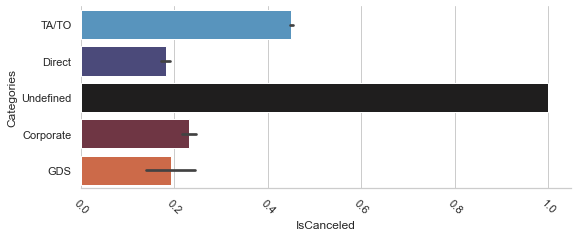

In [30]:
weight_of_variable(data,"DistributionChannel",target)

### ReservedRoomType

,Total count,Cancelled count,Weight
A,62593,27247,0.435304
D,11767,4147,0.352426
F,1791,700,0.390843
E,1553,505,0.325177
B,1115,368,0.330045
G,484,119,0.245868
C,14,5,0.357143
P,10,10,1.000000


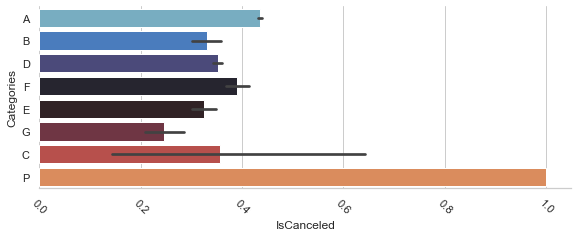

In [31]:
weight_of_variable(data,"ReservedRoomType",target)

### Check for multivariate corellations

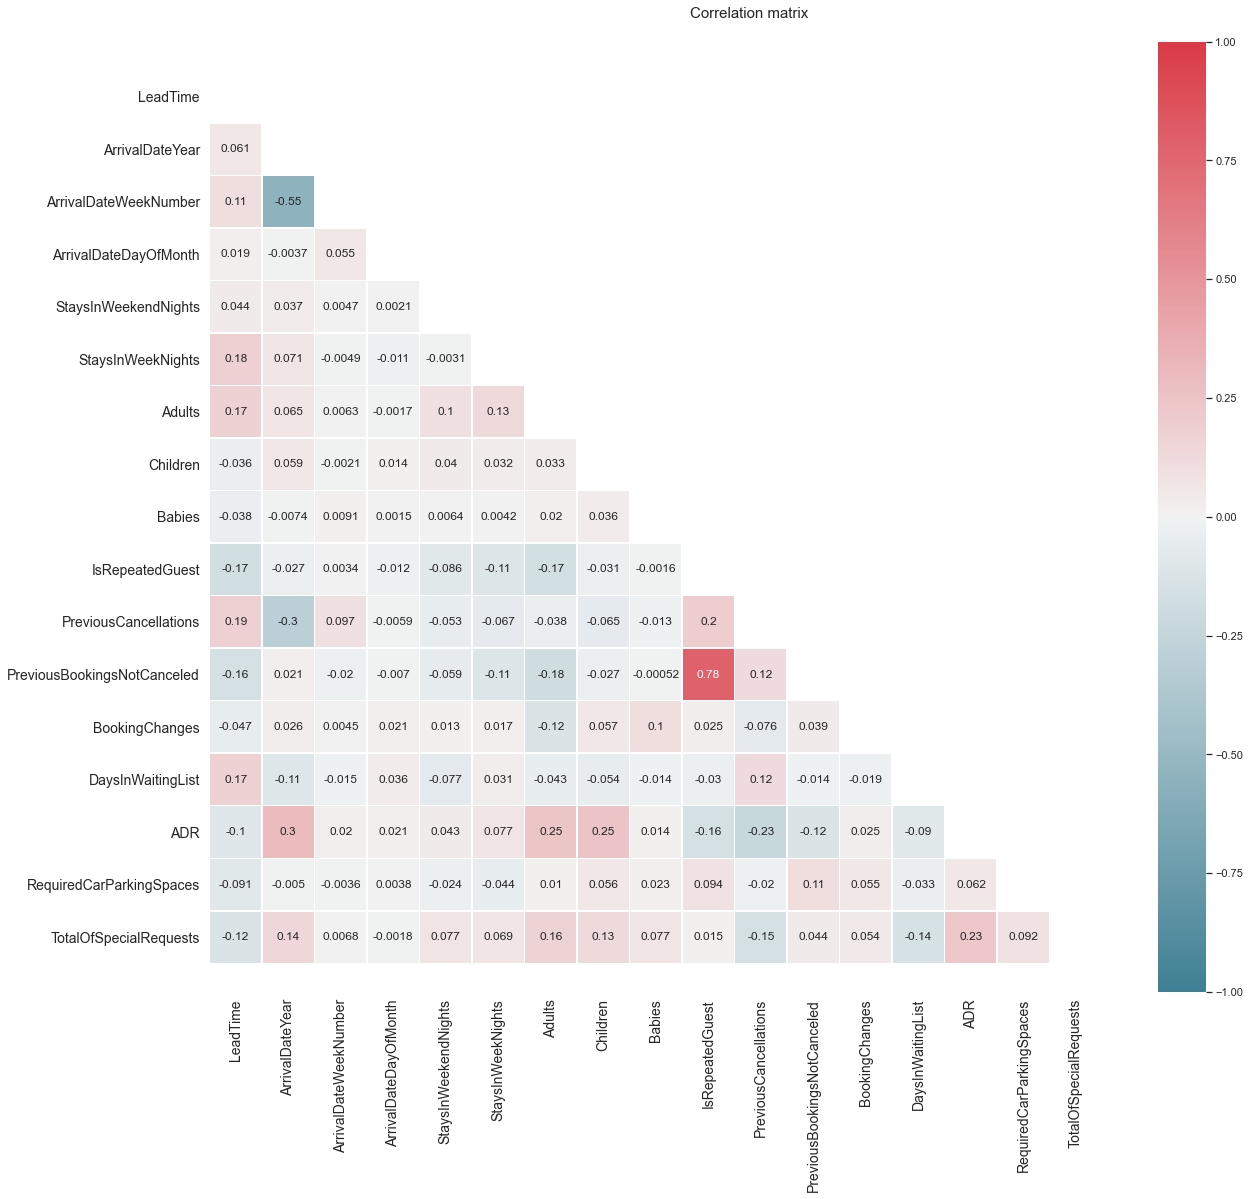

In [33]:
corrheatmap(data[numeric_feats], method = 'spearman')

**Summary notes:**
- `Iscanceled` is the target variable
- `ReservationStatus` : possible target information leakage
- There are only a few NaNs in the variables `Children` and `Country`
- There are many duplicated rows in the data. Nevertheless, it was specified by the company that it's a coincidence, they're not duplicated customers
- No relevant correlations detected among the metric features
- Data contained outliers 
- `LeadTime`: Most of booking for more than 275 days ahead will be canceled. Bookings at 1 day before the arrival has lowest probability of cancelation
- `Country`: Customers of the hotel mostly come from Portugal, which is quite obvious as the hotel is in Portugal. However, the number of canceled bookings from Portugal is extremely high, nearly double the number of confirmed bookings while the ratio is completely opposite in other countries
- `IsRepeatedGuest`: Most of the bookings is from new customer, which might means that customer is not likely to return to the hotel after staying. This can be interpreted that this hotel is in the city which attract 1-time tourist and businessmans.

# 3. Data preprocessing <a class="anchor" id="3"></a>

In [37]:
data.describe(exclude=[np.number])

,ArrivalDateMonth,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate
count,79327,79327,79303,79327,79327,79327,79327,79327,79327,79327,79327,79327,79327
unique,12,4,166,8,5,8,9,3,224,208,4,3,864
top,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Check-Out,2015-10-21
freq,8983,62302,30958,38747,68943,62593,57006,66440,31954,75638,59402,46226,1416


### Drop NA values

In [38]:
data.dropna(inplace=True)

### Drop Outliers

In [39]:
data.drop(index=outlier_index,inplace=True, errors='ignore')

### Detect Outliers with DBSCAN

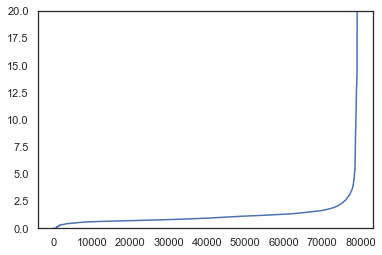

In [40]:
# computing the DBSCAN for outliers

# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=100)
df = pd.DataFrame(RobustScaler().fit_transform(data[numeric_feats]), columns=numeric_feats, index = data.index)
neigh.fit(df)
distances, _ = neigh.kneighbors(df)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylim(0,20)
plt.show()

In [41]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=4, min_samples=150, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(data[numeric_feats])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 7


<AxesSubplot:ylabel='count'>

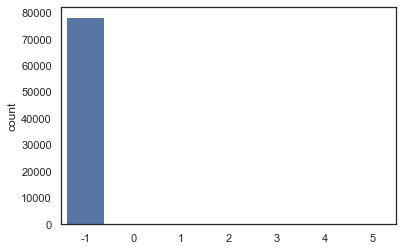

In [42]:
# Concatenating the labels to df
sns.countplot(dbscan_labels)

In [43]:
# the observations identified as outliers are the ones with labels = -1 
# dispaying the outliers detected
print('Number of outliers detected by DBSCAN :', np.sum(dbscan_labels == -1))

Number of outliers detected by DBSCAN : 78326


We tried to use the unsupervised DBSCAN algorithm to detect the outliers. However, the input space seems to be not the most adeguate for this kind of detection. The number of outliers detected is too high.\
The only outliers removed are the ones detected during the EDA.

## 4. Predictive Modelling: <a class="anchor" id="4"></a>

In [44]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('_________________________________________________________________________________________')
    print('                                       TRAIN                                          ')
    print('-----------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train,digits=4))
    print(confusion_matrix(y_train, pred_train))


    print('__________________________________________________________________________________________')
    print('                                      VALIDATION                                          ')
    print('------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val,digits=4))
    print(confusion_matrix(y_val, pred_val))
def enc_scl_pipe(X_train, y_train, X_test, enc_method, scaler = StandardScaler()): 
    X_train_encoded = X_train.copy()
    X_test_encoded= X_test.copy()
    # Set up feature to encode
    feature_to_encode = X_train.columns[X_train.dtypes == 'O'].tolist()
    
    if enc_method == 'label':
        for feat in feature_to_encode:
            # Initia the encoder model
            lbEncoder = LabelEncoder()
            # fit the train data
            lbEncoder.fit(X_train[feat])

            # transform training set
            X_train_encoded[feat] = lbEncoder.transform(X_train[feat])
            # transform test set
            X_test_encoded[feat] = lbEncoder.transform(X_test[feat])
            
    elif enc_method == 'glmm':
        # Initia the encoder model
        GLMMEncoder = ce.glmm.GLMMEncoder(verbose =0 ,binomial_target=True)
        # fit the train data
        GLMMEncoder.fit(X_train[feature_to_encode],y_train)
        # transform training set
        X_train_encoded[feature_to_encode] = GLMMEncoder.transform(X_train[feature_to_encode])
        # transform test set
        X_test_encoded[feature_to_encode] = GLMMEncoder.transform(X_test[feature_to_encode])
    else:
        raise 'No encoding method stated'
        
    # fit the scaler                    
    scaler.fit(X_train_encoded)
    # transform training set
    X_train_scaled = pd.DataFrame(scaler.transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
    # transform test set
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)
    
    return X_train_scaled, X_test_scaled, (GLMMEncoder, scaler)

def model_fit(model, model_name, X_train, y_train, X_test, y_test,  scores):
    '''This function is for training and measure the executed time of each model'''
    begin = time.perf_counter()
    model.fit(X_train, y_train)
    end = time.perf_counter()
    # Run cross-validation on training set
    train_score = accuracy_score(y_train, model.predict(X_train))
    test_score = accuracy_score(y_test, model.predict(X_test))
    train_recall = recall_score(y_train, model.predict(X_train))
    test_recall = recall_score(y_test, model.predict(X_test))
    train_precision = precision_score(y_train, model.predict(X_train))
    test_precision = precision_score(y_test, model.predict(X_test))
    
    # finish counting time

    # assign infomation
    scores[model_name] = [train_score, test_score,train_precision,test_precision, train_recall, test_recall, round(end-begin,3)]
    return model, scores
def plot_learning_curve(estimators, names, X, y, ylim=None, cv=KFold(n_splits=5),
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex="all", figsize=(16,12))
    sns.set_style("white")
    for estimator, title, ax in zip(estimators, names, axes.flatten()):
        """Generate a simple plot of the test and training learning curve"""
        train_sizes, train_scores, test_scores = learning_curve(
                                                estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.legend(loc = 'best')
        title = title + " learning curve"
        ax.grid(b= True)
        ax.set_title(title)
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")   
    return plt
def plot_models_roc_curve(models,X_train,y_train, X_test, y_test):
    fig ,ax = plt.subplots(figsize = (8,8))
    for model in models:
        model.fit(X_train, y_train)
        plot_roc_curve(model, X_test, y_test,ax = ax)      

    plt.title("ROC curve comparison")
    plt.show() 

#### Notes from previous steps
Variables to drop 
- `ArrivalDateYear` : it's not useful for a prediction, because the goal is to predict the next customers
- `ReservationStatus` : it's possible to store this information only when the customer arrives
- `ReservationStatusDate` : other variables are more relevant and repeat info (ex. LeadTime)
- `Country`: The value of the Country variable is only known for sure after the customer has made at least one check-in in the past, even then the quality of the variables isn't very reliable
- `Babies` : the majority of the customers has the same value (0 --> more than 95 %)
- `DepositType` : this variable is incorrect

In [45]:
train = data.drop(columns=['ArrivalDateYear','ReservationStatus','ReservationStatusDate','Country','DepositType','IsCanceled'])
target = data.loc[:,'IsCanceled']

In [50]:
lgb_params = { 'colsample_bytree': 0.9,
                 'subsample': 1,
                 'learning_rate': 0.05,
                 'max_depth': 23,
                 'num_leaves': 800,
                 'min_child_samples': 50,
                 'random_state': 2,
                 'verbose':-1,
                 'n_estimators': 300                 
                 }
rf_params = {'max_depth': 25,
            'min_samples_leaf':2,
            'random_state':2,
            'n_jobs':-1}

In [51]:
scores = {}
models = [(LogisticRegression(), 'Logistics Regression'),
          (lgb.LGBMClassifier(boosting_type='gbdt',random_state = 2),'LightGBM_baseline'),
          (lgb.LGBMClassifier(boosting_type='gbdt',**lgb_params), 'LightGBM_tuned'),
          (RandomForestClassifier(), 'Random Forest'),
          (RandomForestClassifier(**rf_params), 'Random Forest_tuned')]

trained_model = {}
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3,  random_state=2)
X_train, X_test, _ =  enc_scl_pipe(X_train, y_train, X_test, enc_method='glmm', scaler=StandardScaler())
for model, name in models:    
    model_fitted , scores = model_fit(model, name, X_train, y_train, X_test, y_test,  scores) 
    trained_model[name] = model_fitted
    
final_score = pd.DataFrame.from_dict(scores, orient='index',columns=['Train acc','Test acc',
                                                                     'Train Precision', 'Test Precision',
                                                                     'Train Recall','Test Recall','Training time'])

In [52]:
final_score

,Train acc,Test acc,Train Precision,Test Precision,Train Recall,Test Recall,Training time
Logistics Regression,0.802068,0.803195,0.799871,0.800432,0.699433,0.706679,0.184
LightGBM_baseline,0.853177,0.850105,0.885327,0.881310,0.743540,0.742379,0.423
LightGBM_tuned,0.969591,0.868768,0.968497,0.871556,0.958101,0.805656,6.033
Random Forest,0.991407,0.872005,0.992298,0.887720,0.987015,0.795227,6.231
Random Forest_tuned,0.925147,0.869945,0.938855,0.894743,0.877289,0.781689,1.541


The tuned gradient boosting model showed slightly better result but it also requires more time to train. The RandomForest model showed the best result, however, it is extremely overfitting. 

We tried to control the overfitting for Random Forest and improve the score of Gradient Boosting by tuning the hyperparameters. The result is slightly better. Thus, for the trade off in time efficient and generalization, we will consider the Random Forest with tuned parameters.

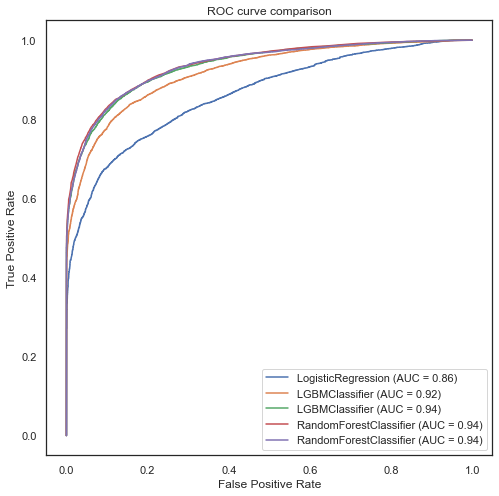

In [98]:
plot_models_roc_curve(trained_model.values(),X_train, y_train, X_test, y_test)

### Cross validation the model results

In [110]:
def kfold_CV_pipe(train_data, target_data, model, columns, enc_method, n_splits = 5):
    all_scores = []
    # set up k-fold
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=2)
    test_preds = 0
    for  f, (trn_idx, val_idx) in enumerate(kf.split(train_data, target_data)):
        # set up the splitted data
        train_       , val_        = train_data.iloc[trn_idx][columns], train_data.iloc[val_idx][columns]
        train_target, val_target = target_data.iloc[trn_idx]              , target_data.iloc[val_idx]
        # encode
        train_, val_, _ =  enc_scl_pipe(train_, train_target, val_, enc_method=enc_method) 
        # model fitting
      
        model.fit(train_, train_target)

        # get predicted values for oof data and whole test set
        temp_oof = model.predict(val_)
        # get predicted values for whole data set aggregate from each fold iter
        fold_score = recall_score(val_target,temp_oof)
        all_scores.append(fold_score)
        print(f"Fold {f} : {fold_score}")
    return all_scores

In [111]:
train = data.drop(columns=['ArrivalDateYear','ReservationStatus','ReservationStatusDate','Country','DepositType','IsCanceled'])
target = data.loc[:,'IsCanceled']

In [112]:
model = RandomForestClassifier(**rf_params)
# Perform cross validation
all_scores = kfold_CV_pipe(train, target, model, enc_method = 'glmm' ,columns = train.columns)

Fold 0 : 0.7845804988662132
Fold 1 : 0.7762660619803476
Fold 2 : 0.7724867724867724
Fold 3 : 0.7779289493575208
Fold 4 : 0.7777777777777778


In [114]:
print(f'Average 5-fold cross validation Recall score of the full dataset {np.mean(all_scores):.4f}')

Average 5-fold cross validation Recall score of the full dataset 0.7778


### Confusion matrix assessment

In [79]:
# fit the whole training set
X_train, X_test, _ =  enc_scl_pipe(X_train, y_train, X_test, enc_method='glmm', scaler=StandardScaler())

In [80]:
#model = lgb.LGBMClassifier(boosting_type='gbdt',random_state=2)
model = RandomForestClassifier(**rf_params)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_jobs=-1,
                       random_state=2)

In [81]:
metrics(y_train, model.predict(X_train.loc[:,:]), y_test, model.predict(X_test.loc[:,:]))

_________________________________________________________________________________________
                                       TRAIN                                          
-----------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9175    0.9603    0.9384     32399
           1     0.9405    0.8789    0.9087     23110

    accuracy                         0.9264     55509
   macro avg     0.9290    0.9196    0.9235     55509
weighted avg     0.9271    0.9264    0.9260     55509

[[31114  1285]
 [ 2798 20312]]
__________________________________________________________________________________________
                                      VALIDATION                                          
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8531    0.9314    0.8906    

In [99]:
result_proba = model.predict_proba(X_test)
result_proba = result_proba[(result_proba[:,1] >= 0.5)][:,1]

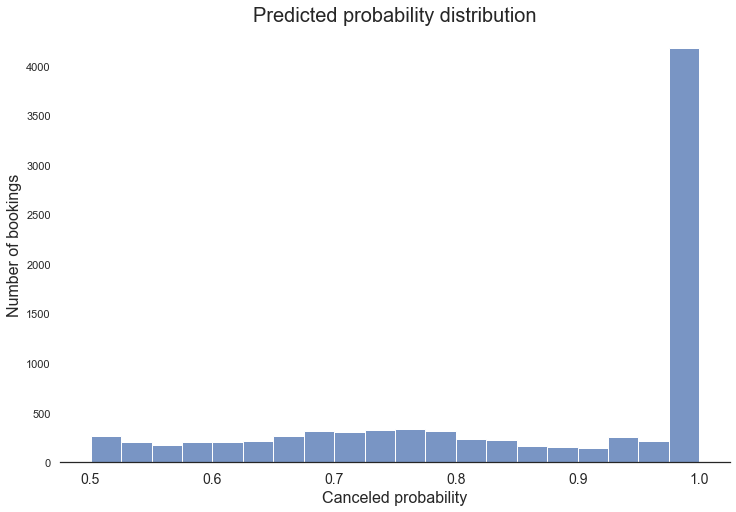

In [106]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.displot(result_proba)
sns.despine(left=True)
plt.title("Predicted probability distribution", fontsize=20)
plt.xlabel("Canceled probability", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("Number of bookings", fontsize=16)
#plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

**Choice of the measure:**

Considering the business context, the most damaging error is the False Negative, because a customer who will potentially cancel is a probem that really matters for the hotel in terms of revenue.

The marginal loss in terms of revenue due to a cancellation is worse than a gift offered to a customer who will not cancel.
Considering the business needs, thus, it's advisable to focus on the reduction of the false negatives, as much as possible. 

In order to take it into consideration, the best choice of measure is the Recall, that consider the True positive / false negatives, in particular focused on the prediction of class "IsCancel" = 1. Getting a high recall means reducing the false negatives error.

### Features important assessment

#### Gradient Boosting model

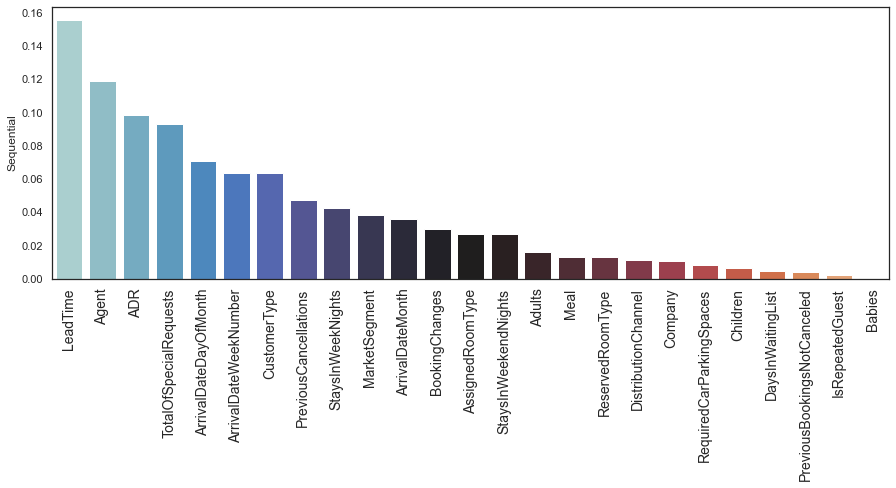

In [208]:
# using gradient boosting model
model = lgb.LGBMClassifier(boosting_type='gbdt',random_state=2)
model.fit(X_train,y_train)

feats_imp = pd.Series(data = model.feature_importances_,index = X_train.columns)
feats_imp.sort_values(ascending=False,inplace=True)

fig,ax = plt.subplots(figsize=(15, 5), sharex=True)
# Generate some sequential data
sns.barplot(y=feats_imp.values, x= feats_imp.index, palette="icefire", ax=ax,)
ax.set_ylabel("Sequential")
plt.xticks(rotation=90, fontsize = 14)
plt.show()

#### Random forest model 

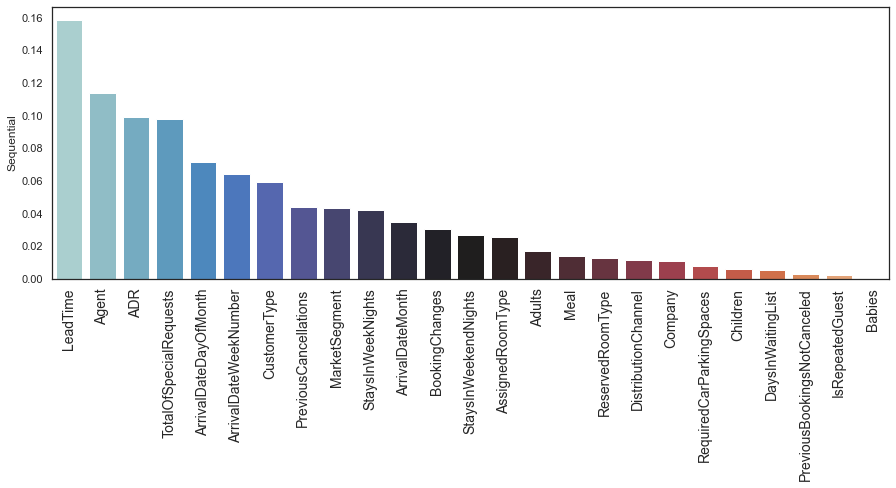

In [209]:
# Using random forest model
model = RandomForestClassifier(**rf_params)
model.fit(X_train,y_train)

feats_imp = pd.Series(data = model.feature_importances_,index = X_train.columns)
feats_imp.sort_values(ascending=False,inplace=True)

fig,ax = plt.subplots(figsize=(15, 5), sharex=True)
# Generate some sequential data
sns.barplot(y=feats_imp.values, x= feats_imp.index, palette="icefire", ax=ax,)
ax.set_ylabel("Sequential")
plt.xticks(rotation=90, fontsize = 14)
plt.show()

No handles with labels found to put in legend.


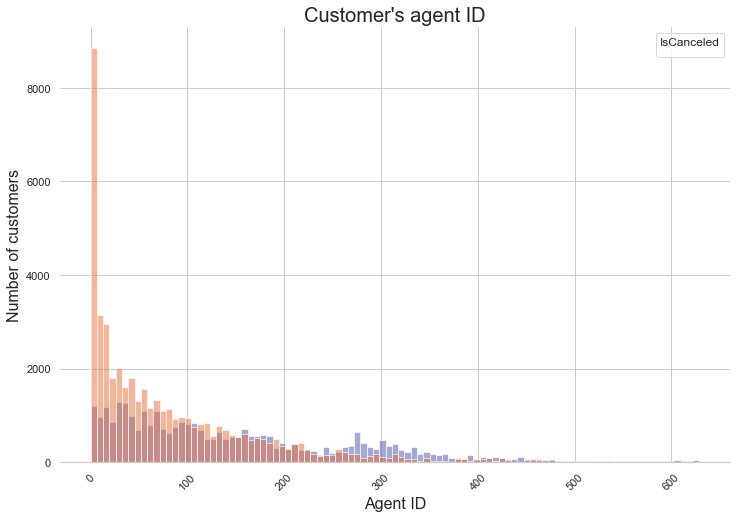

In [63]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.histplot(data=data, x="LeadTime", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
              #order = pd.value_counts(data['LeadTime']).iloc[:10].index)
sns.despine(left=True)
plt.title("Customer's agent ID", fontsize=20)
plt.xlabel("Agent ID", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of customers", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

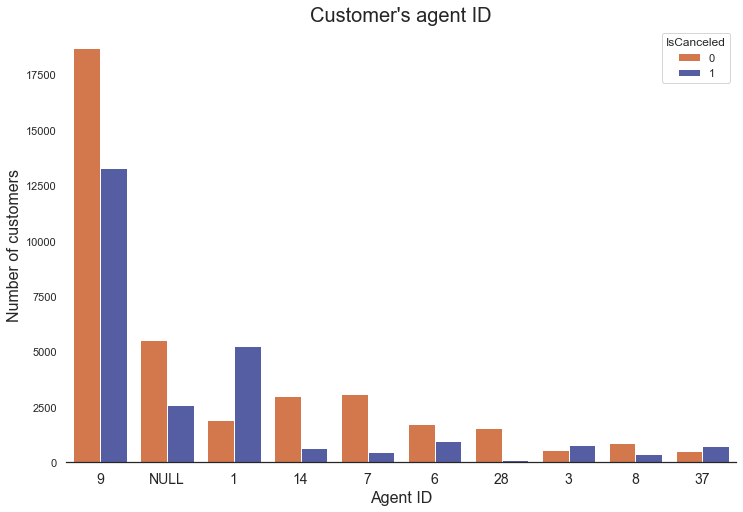

In [110]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="Agent", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)],
              order = pd.value_counts(data['Agent']).iloc[:10].index)
sns.despine(left=True)
plt.title("Customer's agent ID", fontsize=20)
plt.xlabel("Agent ID", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("Number of customers", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

Some of the travel agencies have really high cancelation rate. We should have some policies to apply for them

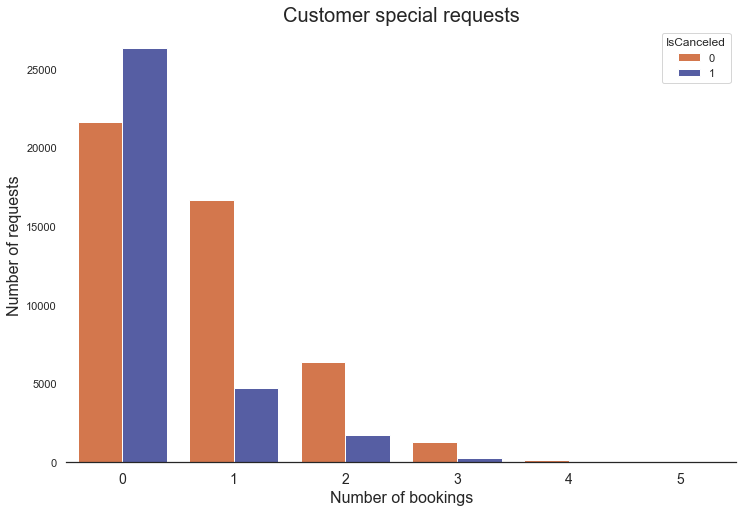

In [109]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="TotalOfSpecialRequests", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)],
              order = pd.value_counts(data['TotalOfSpecialRequests']).iloc[:10].index)
sns.despine(left=True)
plt.title("Customer special requests", fontsize=20)
plt.xlabel("Number of bookings", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("Number of requests", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

To be more practical in the deployment of the model, we also build an API to test the model prediction on new customer to know which cluster they belong to

In [122]:
#Prepare model for the api
train_encoded = train.copy()
# Saving  encoder
feature_to_encode = train.columns[train.dtypes == 'O'].tolist()
# Initia the encoder model
GLMMEncoder = ce.glmm.GLMMEncoder(verbose =0 ,binomial_target=True)
# fit the train data
GLMMEncoder.fit(train_encoded[feature_to_encode],target)
train_encoded[feature_to_encode] = GLMMEncoder.transform(train[feature_to_encode])
# fit the scaler     
scaler = StandardScaler()
scaler.fit(train_encoded)
# transform training set
train_encoded_scl = pd.DataFrame(scaler.transform(train_encoded), columns=train_encoded.columns, index=train_encoded.index)
#
#train_encoded_scl = box_cox(train_encoded_scl,feats_to_transform)
#final
model = RandomForestClassifier(**rf_params)
model.fit(train_encoded_scl,target)   

RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_jobs=-1,
                       random_state=2)

In [137]:
test_id = 2
PROJECT_ROOT = Path(os.path.abspath('')).resolve()
out_path = os.path.join(PROJECT_ROOT, 'app','model')

dump(scaler, os.path.join(out_path, 'scaler{}.joblib'.format(test_id)))
#encoder
encoder = GLMMEncoder
dump(encoder, os.path.join(out_path, 'encoder{}.joblib'.format(test_id)))
# Saving best model
best_rf = model
dump(best_rf, os.path.join(out_path, 'best_rf{}.joblib'.format(test_id)))

['C:\\Users\\Admin\\Documents\\0.DSAA2020\\Jupyter Notebook\\Business Case\\Case 2\\app\\model\\best_rf2.joblib']

#### Data to feed in the API
- Good booking: 6,July,27,1,0,2,1,0.0,0,HB,Offline TA/TO,TA/TO,0,0,0,A,A,0,6,NULL,0,Transient,0.0,0,0
- Canceled booking: 88,July,27,1,0,4,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,A,0,9,NULL,0,Transient,76.5,0,1
- High probability: 68,July,27,4,2,1,1,0.0,0,BB,Online TA,TA/TO,0,0,0,A,A,0,9,NULL,0,Transient,68.0,0,0

## 5. Evaluation <a class="anchor" id="5"></a>

### Evaluate results
In order to present the evaluation of the results based on the business context, the main focus we want to present is the interpretation of the probability that the predictive model provides. Based on that, the company could take its conclusions and have a better idea of the business actions to avoid and prevent the problem of the booking cancellations, that really matters in terms of loss of revenue. 

Probability of booking cancellations:

- **0 – 50 % of probability**: based on data, this customer has a low probability to cancel the booking, thus no more action is required
- **50 – 80 % of probability**: this customer has a relevant percentage of probability to cancel. So, probably the revenue manager could be interested to make some business or marketing choices to avoid the cancellation of this customer, such as offering some kind of promotion to this customer in order to avoid the cancellation. Some possibilities that could interest the customer could be the free parking, discount for children, free meal or similar offers.
- **80 – 100 % of probability**: this customer has a very high probability to cancel. The data will not provide more information for a better or accurate profile of the customer, but it’s probable that having a really high probability of cancellations means that many factors can affect his decision. So, the manager has take into consideration this probability in the business context. We can suggest to actually overbook the rooms of this customers, because they are only the … % of the total customers arriving to the hotel and they will very probably cancel.


### Review process
Major steps conducted in the project:
- Data transformation:
- Data normalization: 
- Modeling: Logistic Regression, Gradient Boosting, Random Forest
- Evaluation: Recall optimization

All the steps are conducted successfully and contribute to the final result

We will proceed to deploy the proposed model as it already satisfies the business goals and the data mining goals.

## 6. Deployment: <a class="anchor" id="6"></a>
Deployment is a crucial part of every business project. A machine learning model will not be able to drive values if it is not effectively deployed in the real-world context.


### Plan deployment
The deployment phase of every company is really crucial for the business context. It provides a better idea about the effective usage of the machine learning algorithm created, designing a possible bridge between the business goals and the machine learning goals, applying the algorithm in a real-world context.

In this project we focused on the creation of a predictive model for the booking cancellations, thus it would be very useful for the manager and in general for the revenue department of the Hotel Chain to have this prediction easily at handy.

In order to improve the accessibility of the results we obtained for the company, our team have created an API that enables the directly use of the supervised algorithm developed.

The application retrieves a different kind of output based on the probability of the cancellation for each customer, as already explained in the previous paragraph. Basically the application provides to the manager a directly insight and information about the typology of the customer based on the probability of cancellation, simply inserting the input data and pressing the predict button

Future steps to successfully deploy the model:
- Develop fully functioned application: the final solution that able to be scale up to all the organization. The application should be able to allow continuous data fed in, continuous training and evaluation. The application will accept new data for prediction and validated results of new data as additional training data.

- Periodical maintenance plan should be able to continuous evaluate key metrics of the cluster analysis objectives which is, for example, the ratio of canceled bookings after applying methods to keep customers with predicted cancelation

### Plan monitoring and maintenance

Regarding the maintenance plan, the dataset provided was in a good condition and was necessary just a relatively quick pre processing phase, nevertheless in order to provide better result or at least to ensure the same level of quality of the prediction, the supervised model needs to be fed with the same amount of data, if available even more. 

As we created a predictive model, the more data are provided, the better will be the prediction. It’s also very important to maintain the quality of the data and the structure of the variables as similar as possible. We can understand that this could not be possible always in a company, due to technical problems or maybe some improvements or changes on the storing phase of the data. For instance, the introduction of new records with different values can be supported by the model, but if the structure of the dataset will change, it’s advisable to re-train and build another model from scratch, in order to have the best result.


### Produce final report and presentation
Will be introduce at the project presentation
